In [45]:
import numpy as np
import matplotlib.pyplot as plt
import sys

# Import the cooling function
sys.path.insert(0, f"cooling_scripts/")
import cooling_scripts.cooling_fn as cf

sys.path.insert(0, f"helper_scripts/")
import helper_scripts.v_turb as vt

## Cooling function


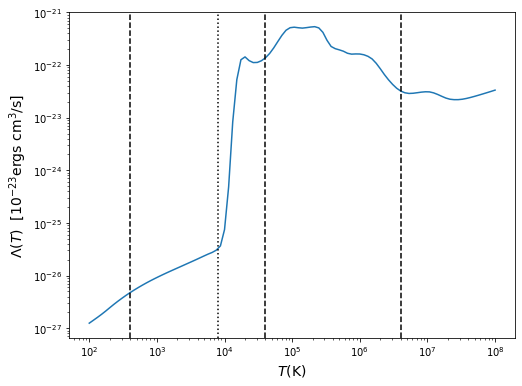

In [3]:
T_arr = np.logspace(2, 8, 100)
rho_arr = rho_hot * np.max(T_arr) / T_arr

Gamma_n_arr = 1e-26 / rho_arr

Lambda_arr = np.vectorize(cf.Lam_fn_powerlaw)(T_arr, Zsol=1.0, Lambda_fac=1.0)

plt.figure(figsize=(8, 6))
plt.plot(T_arr, Lambda_arr, label=r"$\Lambda(T)$")

plt.ylabel(r"$\Lambda(T)$  $[10^{-23}  \mathrm{ergs ~ cm}^3/\mathrm{s}]$", fontsize=14)
plt.xlabel(r"$T$(K)", fontsize=14)

plt.yscale("log")
plt.xscale("log")

plt.axvline(x=4e2, color="k", linestyle="--")
plt.axvline(x=4e4, color="k", linestyle="--")
plt.axvline(x=4e6, color="k", linestyle="--")
plt.axvline(x=8e3, color="k", linestyle=":")

## Cooling and heating rates


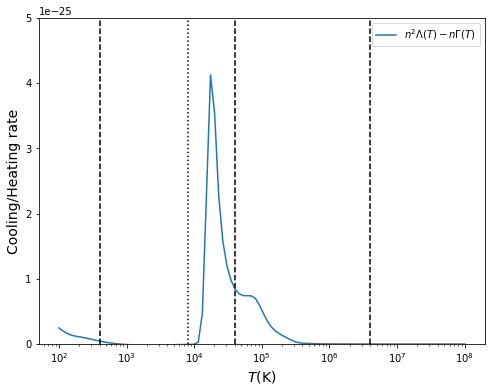

In [111]:
rho_hot = 1e-5

T_arr = np.logspace(2, 8, 100)
rho_arr = rho_hot * np.max(T_arr) / T_arr

heating_rate = 1e-26 * rho_arr

Lambda_arr = np.vectorize(cf.Lam_fn_powerlaw)(T_arr, Zsol=1.0, Lambda_fac=1.0)
cooling_rate = Lambda_arr * rho_arr**2

plt.figure(figsize=(8, 6))
# plt.plot(T_arr, cooling_rate, label=r"$n^2\Lambda(T)$")
plt.plot(T_arr, cooling_rate - heating_rate, label=r"$n^2\Lambda(T) - n\Gamma(T) $")
# plt.plot(T_arr, heating_rate, label=r"$n\Gamma(T)$")

plt.ylabel(r"Cooling/Heating rate", fontsize=14)
plt.xlabel(r"$T$(K)", fontsize=14)

# plt.yscale("log")
plt.xscale("log")

plt.ylim(0.0, 5e-25)

plt.legend()

plt.axvline(x=4e2, color="k", linestyle="--")
plt.axvline(x=4e4, color="k", linestyle="--")
plt.axvline(x=4e6, color="k", linestyle="--")
plt.axvline(x=8e3, color="k", linestyle=":")

## Cooling timescale


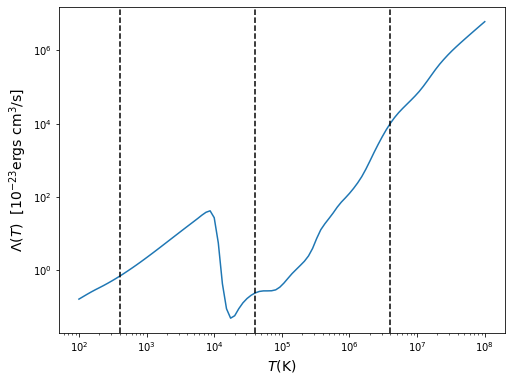

In [5]:
T_arr = np.logspace(2, 8, 100)
rho_arr = rho_hot * np.max(T_arr) / T_arr

tcool_arr = np.vectorize(cf.tcool_calc)(
    rho_arr, T_arr, Zsol=1.0, Lambda_fac=1.0, fit_type="max"
)

plt.figure(figsize=(8, 6))
plt.plot(T_arr, tcool_arr, label=r"$\Lambda(T)$")

plt.ylabel(r"$\Lambda(T)$  $[10^{-23}  \mathrm{ergs ~ cm}^3/\mathrm{s}]$", fontsize=14)
plt.xlabel(r"$T$(K)", fontsize=14)

plt.yscale("log")
plt.xscale("log")

plt.axvline(x=4e2, color="k", linestyle="--")
plt.axvline(x=4e4, color="k", linestyle="--")
plt.axvline(x=4e6, color="k", linestyle="--")
plt.axvline(x=8e3, color="k", linestyle="")

## Cooling equilibrium


In [104]:
rho_hot = 1e-5
Lbox = 1e-1
M = 0.5

T_amb = 4e6

L_T = 100
L_rho = 100

turb_heat_flag = False

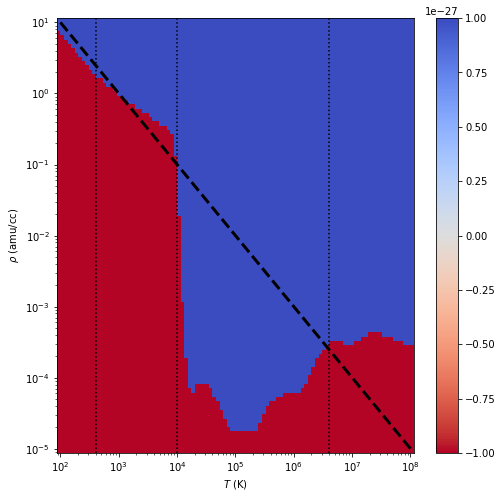

In [108]:
T_arr = np.logspace(2, 8, L_T)
rho_arr = np.logspace(np.log10(rho_hot), np.log10(rho_hot) + 6, L_rho)

v_turb = M * vt.cs_calc(T_hot=T_amb)

rho_isobaric_arr = rho_hot * np.max(T_arr) / T_arr
Lambda_arr = np.vectorize(cf.Lam_fn_powerlaw)(T_arr, Zsol=1.0, Lambda_fac=1.0)

cooling_rate = np.zeros((L_rho, L_T))
heating_rate = np.zeros((L_rho, L_T))

turb_rate = np.zeros((L_rho, L_T))
if turb_heat_flag:
    turb_rate += 0.5 * (rho_hot * np.max(T_arr) / T_amb)
    turb_rate *= v_turb**3 / Lbox
    turb_rate *= (vt.g.unit_density * vt.g.unit_velocity**3) / vt.g.unit_length


for i_rho, rho in enumerate(rho_arr):
    cooling_rate[i_rho, :] = Lambda_arr * rho**2
    heating_rate[i_rho, :] = 1e-26 * rho * np.ones(L_T, dtype=float)

rho_image = np.ones(L_rho + 1, dtype=float)
T_image = np.ones(L_T + 1, dtype=float)

rho_image[:-1] = rho_arr * (rho_arr[0] / rho_arr[1])
rho_image[-1] = rho_arr[-1] * (rho_arr[1] / rho_arr[0])

T_image[:-1] = T_arr * (T_arr[0] / T_arr[1])
T_image[-1] = T_arr[-1] * (T_arr[1] / T_arr[0])

fig, ax = plt.subplots(figsize=(8, 8))
pc = ax.pcolormesh(
    T_image,
    rho_image,
    np.sign(cooling_rate - heating_rate - turb_rate),
    # (cooling_rate - heating_rate - turb_rate),
    cmap="coolwarm_r",
    vmin=-np.min([np.max(cooling_rate), np.max(heating_rate)]) / 100,
    vmax=np.min([np.max(cooling_rate), np.max(heating_rate)]) / 100,
)

ax.plot(T_arr, rho_isobaric_arr, "k--", lw=3)
ax.axvline(4e6, color="k", linestyle=":")
ax.axvline(1e4, color="k", linestyle=":")
ax.axvline(4e2, color="k", linestyle=":")

ax.set_ylabel(r"$\rho$ (amu/cc)")
ax.set_xlabel(r"$T$ (K)")

ax.set_yscale("log")
ax.set_xscale("log")

fig.colorbar(pc)